# Figure 5: Composite intronic site analysis

**Description:** Genomic context model development for intron sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import genomic_context

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import test_proportions_2indep


## IMPORT DATA

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"

DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_05")
os.makedirs(OUTDIR, exist_ok = True)

ENCODE_DIR = os.path.join(PROJECT, "model", "rna_validation", "encode_project")


## Data loading and preparation

In [6]:
ic_data = pd.read_csv(os.path.join(RESDIR, 'ic_rawdata.txt'), sep = "\t")
print(ic_data.shape)


(2555604, 33)


#### Define features

In [7]:
ic_feature_dict = {
    'intron_pos_3'               : "6. Site in last intron?",
    'up_exon_log10'              : "2. Upstream exon size (log10)",
    'down_exon_log10'            : "3. Downstream exon size (log10)",
    'distance_upstream5ss_log10' : "1. Distance to 5'SS (log10)",
    'score_upstream5ss'          : "4. Upstream 5'SS strength",
    'score_downstream3ss'        : "5. Downstream 3'SS strength",
    'ratio_size_distance'        : "8. Ratio of intron size to 5'SS distance (log2)",
    'strength'                   : "7. PolyaStrength score",
}

ic_features = list(ic_feature_dict.keys())
ic_labels = [ic_feature_dict.get(_) for _ in ic_features]


#### Transform features

In [8]:
ic_data['gene'] = ic_data['feature_gene']
ic_data['intron_pos_3'] = (ic_data['feature_score'] == 3).astype(int)

ic_data['feature_size_log10']         = np.log10(ic_data['feature_size'] + 1)
ic_data['distance_upstream5ss_log10'] = np.log10(ic_data['distance_upstream5ss'] + 1)
ic_data['up_exon_log10']              = np.log10(ic_data['up_exon'] + 1)
ic_data['down_exon_log10']            = np.log10(ic_data['down_exon'] + 1)

ic_data['distance_downstream3ss'] = ic_data['feature_size'] - ic_data['distance_upstream5ss']
ic_data['position_upstream5ss']   = ic_data.apply(lambda row: (row['start'] - row['distance_upstream5ss']) if (row['strand'] == '+') else (row['start'] + row['distance_upstream5ss']), axis = 1)
ic_data['position_downstream3ss'] = ic_data.apply(lambda row: (row['start'] + row['distance_downstream3ss']) if (row['strand'] == '+') else (row['start'] - row['distance_downstream3ss']), axis = 1)

ic_data['ratio_size_distance'] = np.log2((ic_data['feature_size'] + 100) / (ic_data['distance_upstream5ss'] + 100))


#### Subset sites in well-expressed genes

In [9]:
try:
    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.reads.pickle'), mode = 'rb') as handle:
        gene_reads = pickle.load(handle)
        
except FileNotFoundError:
    
    with open(os.path.join(DATADIR, "reads3_scoring_dictionary.pickle"), mode = 'rb') as handle:
        reads_dict = pickle.load(handle)
        
    gene_reads = {}
        
    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.bed'), mode = 'r') as handle:
        for line in handle:
            
            chrom, start, end, gene, score, strand = line.strip().split("\t")
            
            start = int(float(start))
            end   = int(float(end))
            
            gene_reads[gene] = np.sum([reads_dict.get((strand,chrom,x),0) for x in range(start,end)])

    with open(os.path.join(RESDIR, 'refseq.hg38.genes.minUn.agg.reads.pickle'), mode = 'wb') as handle:
        pickle.dump(gene_reads, handle)

ic_data['gene_reads'] = ic_data['gene'].apply(lambda x : gene_reads[x])


In [10]:
condWELLEXP   = (ic_data['gene_reads'] >= 100)
condNOMISSING = ~(ic_data[ic_features].isnull().any(axis = 1))
print(condWELLEXP.sum(), condNOMISSING.sum())

ic_filt = ic_data.loc[condWELLEXP & condNOMISSING].copy()
print(ic_filt.shape)


2352172 2555604
(2352172, 43)


#### Identify positive sites

In [11]:
ic_pos = ic_filt.loc[ic_filt['cluster_reads_slop'] > 0].copy()

ic_site_dict = {}

for i,row in ic_pos.iterrows():
    ic_site_dict[(row['chrom'], row['start'], row['strand'], row['gene'])] = row['cluster_reads_slop']


In [12]:
ic_positives = ic_filt.loc[ic_filt['cluster_reads_slop'] >= 100].copy()
ic_negatives = ic_filt.loc[ic_filt['cluster_reads_slop'] == 0].copy()

print("POSITIVES:", ic_positives.shape)
print("NEGATIVES:", ic_negatives.shape)


POSITIVES: (7720, 43)
NEGATIVES: (2266501, 43)


#### Sample negative sites from introns with no used polyA sites

In [13]:
# random_state = np.random.randint(0, 2**32 - 1)
random_state = 2918177320
print(random_state)

ic_negatives_samp = ic_negatives.sample(n = 40000, replace = False, random_state = random_state)
ic_negatives_samp['nc_eligible'] = ic_negatives_samp.apply(genomic_context.check_sites_in_intron, args = (ic_pos, ic_site_dict), axis = 1)
print("ELIGIBLE NCs:", ic_negatives_samp.nc_eligible.sum())


2918177320
ELIGIBLE NCs: 16415


In [14]:
ic_negatives_maxpergene = genomic_context.downsample_sites_per_gene(ic_negatives_samp.loc[ic_negatives_samp['nc_eligible'] == True], 
                                                                    ic_positives['gene'].value_counts().max(),
                                                                    random_state = random_state
                                                                   )
print("DOWNSAMPLED NCs:", ic_negatives_maxpergene.shape)


DOWNSAMPLED NCs: (15693, 44)


#### Partition data into training/testing splits

In [17]:
ic_positives = ic_filt.loc[ic_filt['cluster_reads_slop'] >= 100].copy()
ic_positives['split'] = 'train'
ic_positives.loc[ic_positives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

ic_negatives = ic_negatives_maxpergene.loc[ic_negatives_maxpergene['nc_eligible'] == 1].copy().sample(n = len(ic_positives), replace = False, random_state = random_state)
ic_negatives['split'] = 'train'
ic_negatives.loc[ic_negatives.sample(frac = 0.1, replace = False, random_state = random_state).index, 'split'] = 'test'

new_ic_data = pd.concat([ic_positives, ic_negatives], sort = False, ignore_index = True)
print("\nBINARY CLASS:\n", new_ic_data.score_binary.value_counts())
print("\nSPLIT:\n", new_ic_data.split.value_counts())

with open(os.path.join(RESDIR, 'ic_data.pickle'), mode = 'wb') as handle:
    pickle.dump(new_ic_data, handle)



BINARY CLASS:
 1    7720
0    7720
Name: score_binary, dtype: int64

SPLIT:
 train    13896
test      1544
Name: split, dtype: int64


#### Scale data to normalize mean and standard deviation

In [18]:
scaler_ic = StandardScaler().fit(new_ic_data.loc[new_ic_data['split'] == 'train', ic_features[1:]])

with open(os.path.join(RESDIR, 'ic_scaler_ratio.pickle'), mode = 'wb') as handle:
    pickle.dump(scaler_ic, handle)

Xall_scaled = pd.DataFrame(scaler_ic.transform(new_ic_data[ic_features[1:]]), index = new_ic_data.index, columns = new_ic_data[ic_features[1:]].columns)
Xall_scaled[ic_features[0]] = new_ic_data[ic_features[0]]
Yall_c = new_ic_data['score_binary']

Xtr_scaled = Xall_scaled.loc[new_ic_data['split'] == 'train'].copy()
Ytr_c = new_ic_data.loc[new_ic_data['split'] == 'train', 'score_binary'].copy()

Xte_scaled = Xall_scaled.loc[new_ic_data['split'] == 'test'].copy()
Yte_c = new_ic_data.loc[new_ic_data['split'] == 'test', 'score_binary'].copy()

ic_all_data = {
    'train' : {
        'X' : Xtr_scaled,
        'Y' : Ytr_c,
    },
    'test' : {
        'X' : Xte_scaled,
        'Y' : Yte_c,
    }
}


#### Fit logistic regression model

In [19]:
ic_model = sm.Logit(Ytr_c, Xtr_scaled[ic_features]).fit()
print(ic_model.summary())

with open(os.path.join(RESDIR, 'ic_model_ratio.pickle'), mode = 'wb') as handle:
    pickle.dump(ic_model, handle)


Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           score_binary   No. Observations:                13896
Model:                          Logit   Df Residuals:                    13888
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.4316
Time:                        09:37:30   Log-Likelihood:                -5474.4
converged:                       True   LL-Null:                       -9632.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intron_pos_3                   1.2588      0.098     12.797      0.000      

In [20]:
ic_all_data['train']['Ypred'] = {}
ic_all_data['test']['Ypred']  = {}

new_preds = ic_model.predict(ic_all_data['train']['X'][ic_features])
ic_all_data['train']['Ypred'] = new_preds

new_preds = ic_model.predict(ic_all_data['test']['X'][ic_features])
ic_all_data['test']['Ypred'] = new_preds


## Classification Performance

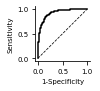

Corresponding metrics:
	Test AUROC = 0.915893715267524


In [21]:
fig,axes = plt.subplots(1,1, figsize = (1,1))

ic_filt_auc = genomic_context.plot_roc(axes, 
                                       ic_all_data['test']['Y'],
                                       ic_all_data['test']['Ypred'],
                                       'Test')

axes.xaxis.set_major_locator(MultipleLocator(0.5))
axes.yaxis.set_major_locator(MultipleLocator(0.5))

axes.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'ic.classification_roc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {ic_filt_auc}")


## Validation of site usage predictions using ENCODE RNA-seq

In [22]:
## load site data with genomic context fields

ic_site_data = ic_filt

ic_site_data_scaled = pd.DataFrame(scaler_ic.transform(ic_site_data[ic_features[1:]]), index = ic_site_data.index, columns = ic_site_data[ic_features[1:]].columns)
ic_site_data_scaled['intron_pos_3'] = ic_site_data['intron_pos_3']

ic_site_data['pred_prob'] = ic_model.predict(ic_site_data_scaled[ic_features])
print(ic_site_data.shape)


## filter sites with sufficient reads

ic_site_pos = ic_site_data.loc[ic_site_data['cluster_reads_slop'] >= 10].copy()
ic_site_neg = ic_site_data.loc[ic_site_data['cluster_reads_slop'] == 0].copy().sample(n = ic_site_pos.shape[0], replace = False, random_state = random_state)

ic_site_filt = pd.concat([ic_site_pos, ic_site_neg], sort = False, ignore_index = True)
print(ic_site_filt.shape)


(2352172, 44)
(72440, 44)


Original data shape: (72440, 44)
Filtered data shape: (71607, 44)
Output results shape: (71607, 2)


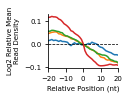

In [23]:
fig, ax = plt.subplots(1,1, figsize = (1.25,1))

distance = 20
ic_a172_res = genomic_context.quantify_reads_around(ic_site_filt, ENCODE_DIR, 'A172', distance = distance, subset = [('distance_upstream5ss', distance+5), ('distance_downstream3ss', distance+5)])
genomic_context.make_read_plots(ax, ic_a172_res, 'composite_intron', 'A172', distance)

ax.axhline(y = 0, color = 'black', linestyle = 'dashed', linewidth = 0.75)
ax.set_xlim((-distance,distance))
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, 'ic.rna_validation.icomp.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## AUROC for individual predictors

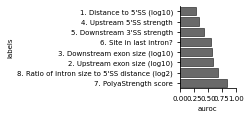

Corresponding data:
                                            labels     auroc     auprc
3                      1. Distance to 5'SS (log10)  0.280273  0.371377
4                        4. Upstream 5'SS strength  0.347808  0.414483
5                      5. Downstream 3'SS strength  0.439091  0.462746
0                          6. Site in last intron?  0.556347  0.671366
2                  3. Downstream exon size (log10)  0.575569  0.583479
1                    2. Upstream exon size (log10)  0.599094  0.585749
6  8. Ratio of intron size to 5'SS distance (log2)  0.675357  0.689684
7                           7. PolyaStrength score  0.838351  0.827676


In [24]:
ic_test_data = new_ic_data.loc[new_ic_data['split'] == 'test']

ic_aurocs = []
ic_auprcs = []

for icf,icl in zip(ic_features, ic_labels):
    auroc, auprc = genomic_context.calculate_auc(ic_test_data['score_binary'], ic_test_data[icf])
    ic_aurocs.append(auroc)
    ic_auprcs.append(auprc)
    
ic_aurocs_df = pd.DataFrame.from_dict({'labels' : ic_labels, 'auroc' : ic_aurocs, 'auprc' : ic_auprcs}, orient = 'columns')

fig,ax = plt.subplots(1,1, figsize = (1, 1.5))

sns.barplot(data = ic_aurocs_df.sort_values('auroc'),
            x = 'auroc', y = 'labels', color = 'dimgray',
            edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlim(0,1)
ax.xaxis.set_major_locator(MultipleLocator(0.25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'ic.individual_predictor_auroc.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(ic_aurocs_df.sort_values('auroc'))


## Confirmatory boxplots for model predictors


In [25]:
class_names = {0:'Not Used', 1:'Highly Used'}
class_order = ['Highly Used', 'Not Used']

ic_pred = new_ic_data.copy()
ic_pred['pred_prob'] = ic_all_data['train']['Ypred']
ic_pred.loc[ic_pred['split'] == 'test', 'pred_prob'] = ic_all_data['test']['Ypred']

ic_pred['class'] = ic_pred['score_binary'].apply(lambda x : class_names[x])
ic_pred['pred_prob_clip'] = np.clip(ic_pred['pred_prob'], 1e-6, 1 - 1e-6)
ic_pred['pred_prob_or'] = np.log2(ic_pred['pred_prob_clip'] / (1 - ic_pred['pred_prob_clip']))

print(ic_pred.shape)


(15440, 49)


In [26]:
selected_features = ['distance_upstream5ss_log10', 'score_upstream5ss', 'score_downstream3ss',
                     'down_exon_log10','up_exon_log10','feature_size_log10', 'ratio_size_distance']
selected_labels = [ic_feature_dict.get(sf) for sf in selected_features]


#### PolyaStrength by site usage

7. PolyaStrength score:
N_Highly Used	N=7720
N_Not Used	N=7720
Baseline	WRS P-val = 0.000E+00


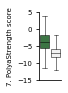

In [27]:
genomic_context.boxplot_features_outcome(OUTDIR, ic_pred, 'ic', 
                                         ['strength'], [ic_feature_dict.get('strength')], 
                                         'class', class_order, ['#337e3d','#f2f2f2'],
                                         figsize = (0.4,1.25), ylims_main=(-15,5), ytickint_main = 5)


#### Genomic features after controlling for PolyaStrength via quantile sampling



1. Distance to 5'SS (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


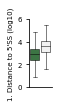

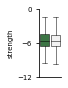

1. Distance to 5'SS (log10):
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 3.280E-225
strength	WRS P-val = 4.559E-01


In [28]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[0]], [selected_labels[0]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(0,6), ytickint_main = 2, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




4. Upstream 5'SS strength
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


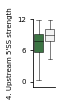

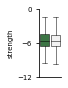

4. Upstream 5'SS strength:
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 3.610E-110
strength	WRS P-val = 4.559E-01


In [29]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[1]], [selected_labels[1]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(-1,12), ytickint_main = 6, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




5. Downstream 3'SS strength
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


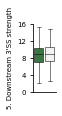

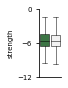

5. Downstream 3'SS strength:
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 1.307E-04
strength	WRS P-val = 4.559E-01


In [30]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[2]], [selected_labels[2]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main=(0,16), ytickint_main = 4, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




3. Downstream exon size (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


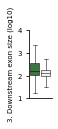

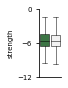

3. Downstream exon size (log10):
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 1.526E-26
strength	WRS P-val = 4.559E-01


In [31]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[3]], [selected_labels[3]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main = (1,4), ytickint_main = 1, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




2. Upstream exon size (log10)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


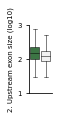

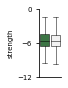

2. Upstream exon size (log10):
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 1.145E-26
strength	WRS P-val = 4.559E-01


In [32]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[4]], [selected_labels[4]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main = (1,3), ytickint_main = 1, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




8. Ratio of intron size to 5'SS distance (log2)
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


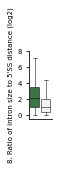

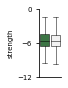

8. Ratio of intron size to 5'SS distance (log2):
N_Highly Used	N=2812
N_Not Used	N=2812
Baseline	WRS P-val = 1.447E-130
strength	WRS P-val = 4.559E-01


In [33]:
genomic_context.boxplot_features_outcome_with_quantile_sampling(OUTDIR, ic_pred, 'ic', 
                                                                [selected_features[6]], [selected_labels[6]], 
                                                                'class', class_order, ['#337e3d','#f2f2f2'],
                                                                sample = ['strength'], random_state = random_state,
                                                                figsize = (0.4,1.25), 
                                                                ylims_main = (-0.5,8), ytickint_main = 2, 
                                                                ylims_sample=(-12,0), ytickint_sample = 6)




6. Site in last intron?
Defining quantiles for variable strength with 10 groups, sampling 75.0% of available sites.


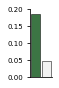

Corresponding Statistics:
statistic = 16.58178285594218
pvalue = 9.438659198735828e-62
compare = diff
method = agresti-caffo
diff = 0.13833570412517782
ratio = 3.969465648854962
odds_ratio = 4.643166406884883
variance = 6.950060245634284e-05
alternative = two-sided
value = 0
tuple = (16.58178285594218, 9.438659198735828e-62)


In [34]:
ic_ip3_sampled = genomic_context.quantile_sampling(ic_pred, 'ic', 
                                                   ['intron_pos_3'], [ic_feature_dict.get('intron_pos_3')], 
                                                   'class', class_order, sample = ['strength'], random_state = random_state)

ic_sum = (ic_ip3_sampled
          .groupby(['class','intron_pos_3']).size()
          .reset_index().rename(columns = {0:'count'}))

ic_sum['prop'] = ic_sum['count'] / ic_sum.groupby('class')['count'].transform('sum')

ic_test = test_proportions_2indep(ic_sum.loc[(ic_sum['class'] == 'Highly Used') & (ic_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  ic_sum.loc[(ic_sum['class'] == 'Highly Used'), 'count'].sum(),
                                  ic_sum.loc[(ic_sum['class'] == 'Not Used') & (ic_sum['intron_pos_3'] == 1), 'count'].iloc[0],
                                  ic_sum.loc[(ic_sum['class'] == 'Not Used'), 'count'].sum())

ic_sum = ic_sum.loc[ic_sum['intron_pos_3'] == 1]


fig,ax = plt.subplots(1,1, figsize = (0.4, 1.25))

sns.barplot(data = ic_sum, x = 'class', y = 'prop', order = class_order,
            hue = 'class', hue_order = class_order, dodge = False, palette = ['#337e3d','#f2f2f2'],
            edgecolor = 'black', linewidth = 0.5)

ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0,0.2)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_xticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'ic.intron_pos_3_by_usage.quantile_sampling.controlling_predicted_logit.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding Statistics:")
print(ic_test)
